In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np
import os
from ripser import ripser
import scipy

import concurrent.futures
from scipy.integrate import ode
import glob
import imageio as io
from itertools import repeat

#make an image of a frame with triangles indicating cell motion
from PIL import Image
from Scripts.arrow_head_marker import *

import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [20]:
def compute_angle_df(filt_df,FRAME_LIST,track_len):
    #make a histogram of velocities (displacement over some number of frames) of all cells at all times
    object = filt_df.copy()
    mags_xy = []
    track_len=10
    for idx in np.arange(track_len,128):
        p_t1=object.particle.values[object.frame==idx-track_len]
        p_t2=object.particle.values[object.frame==idx]

        object2= object[(object["particle"].isin(p_t1)) & (object["particle"].isin(p_t2))]
        frame_t1 = object2[object2['frame']==idx-track_len]
        frame_t2 = object2[object2['frame']==idx]
        delta_x = frame_t2.x.values-frame_t1.x.values
        delta_y = frame_t2.y.values-frame_t1.y.values

        mag_xy = np.sqrt(np.square(delta_x)+np.square(delta_y))
        mags_xy.append(mag_xy)

    mags_xy_data=np.concatenate(mags_xy,axis=0)
    a1,b1,c1=scipy.stats.lognorm.fit(mags_xy_data)
    rv = scipy.stats.lognorm(a1,b1,c1)
    x=np.linspace(0,0.035,100)
#     plt.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
#     n, bins, patches = plt.hist(mags_xy_data, 50, density=True, facecolor='g', alpha=0.75)
    #min_speed=rv.ppf(.25)
    min_speed=0

    ##NEW

    #get fast moving cells, above 25th percentile for displacement over 10 frames
    #min_speed = 0.00656070884994189 #calucated in #figures_for_paper.ipynb
    #go through frames 10 to 126 and add particles to a new data frame
    #only keep those that move fast enough
    #also calculate angle of displacement
    #keep a data frame with x,y,angle,magnitude, and frame
    new_data = pd.DataFrame(columns=['x','y','angle','mag','frame'])

    num_cells_in_frame = []
    num_cells_in_frame_all = []

    for frame_idx in FRAME_LIST:
        p_t1=filt_df.particle.values[filt_df.frame==frame_idx-track_len]
        p_t2=filt_df.particle.values[filt_df.frame==frame_idx]
        object2= filt_df[(filt_df["particle"].isin(p_t1)) & (filt_df["particle"].isin(p_t2))]
        frame_t2 = object2[object2['frame']==frame_idx]
        frame_t1 = object2[object2['frame']==frame_idx-track_len]
        delta_x = frame_t2.x.values-frame_t1.x.values
        delta_y = frame_t2.y.values-frame_t1.y.values
        angle_xy = np.arctan2(delta_y,delta_x)
        deg_xy = np.mod(np.degrees(angle_xy),360)
        mag_xy = np.sqrt(np.square(delta_x)+np.square(delta_y))
        x = frame_t2.x.values
        y = frame_t2.y.values
        count=0
        all_count = 0
        for idx,val in enumerate(x):
            all_count +=1
            if mag_xy[idx]>min_speed:
                count+=1
                df1 = pd.DataFrame({'x':[x[idx]],'y':[y[idx]],'angle':[deg_xy[idx]],'mag':[mag_xy[idx]],'frame':[frame_idx]})
                #print(df1)
                # print(df1)
                new_data=pd.concat([new_data,df1],ignore_index=True,axis=0)
                # print('new data after: ' + str(new_data.shape))
                #sc=ax.scatter(x[idx],y[idx],c=deg_xy[idx],vmin=0,vmax=360,cmap='hsv',marker=marker, s=(markersize*scale)**2)
        num_cells_in_frame.append(count)
        num_cells_in_frame_all.append(len(p_t2))
        
    return new_data

In [22]:
import csv

# Key --> int(w_idx): Value --> list(tuple, tuple, ...) = [(C, L), (C, L), ...]
align_last_frame = {}

file_path = 'last_frame_params.csv'
with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
    # Create a CSV reader object
    csv_reader = csv.reader(csvfile)
    
    # Loop through each row in the CSV file
    for row in csv_reader:
        # Skip the header row
        #print(row[0])
        if row[0] == 'W_idx':
            # print('hi')
            continue
        elif row[0] == str(0) or row[0] == str(5):
            print(row[0])
            widx = int(row[0])
            cl_tup = (int(row[2]), int(row[3]))
            if widx not in align_last_frame.keys():
                align_last_frame[widx] = [cl_tup]
            else:
                align_last_frame[widx].append(cl_tup)
                #print(align_last_frame[widx])

0
0
0
0
0
0
0
0
0
5
5
5
5
5
5
5
5
5


0
new data size: (30000, 5)
Saved & Completed WCL: 0_17_3


KeyboardInterrupt: 

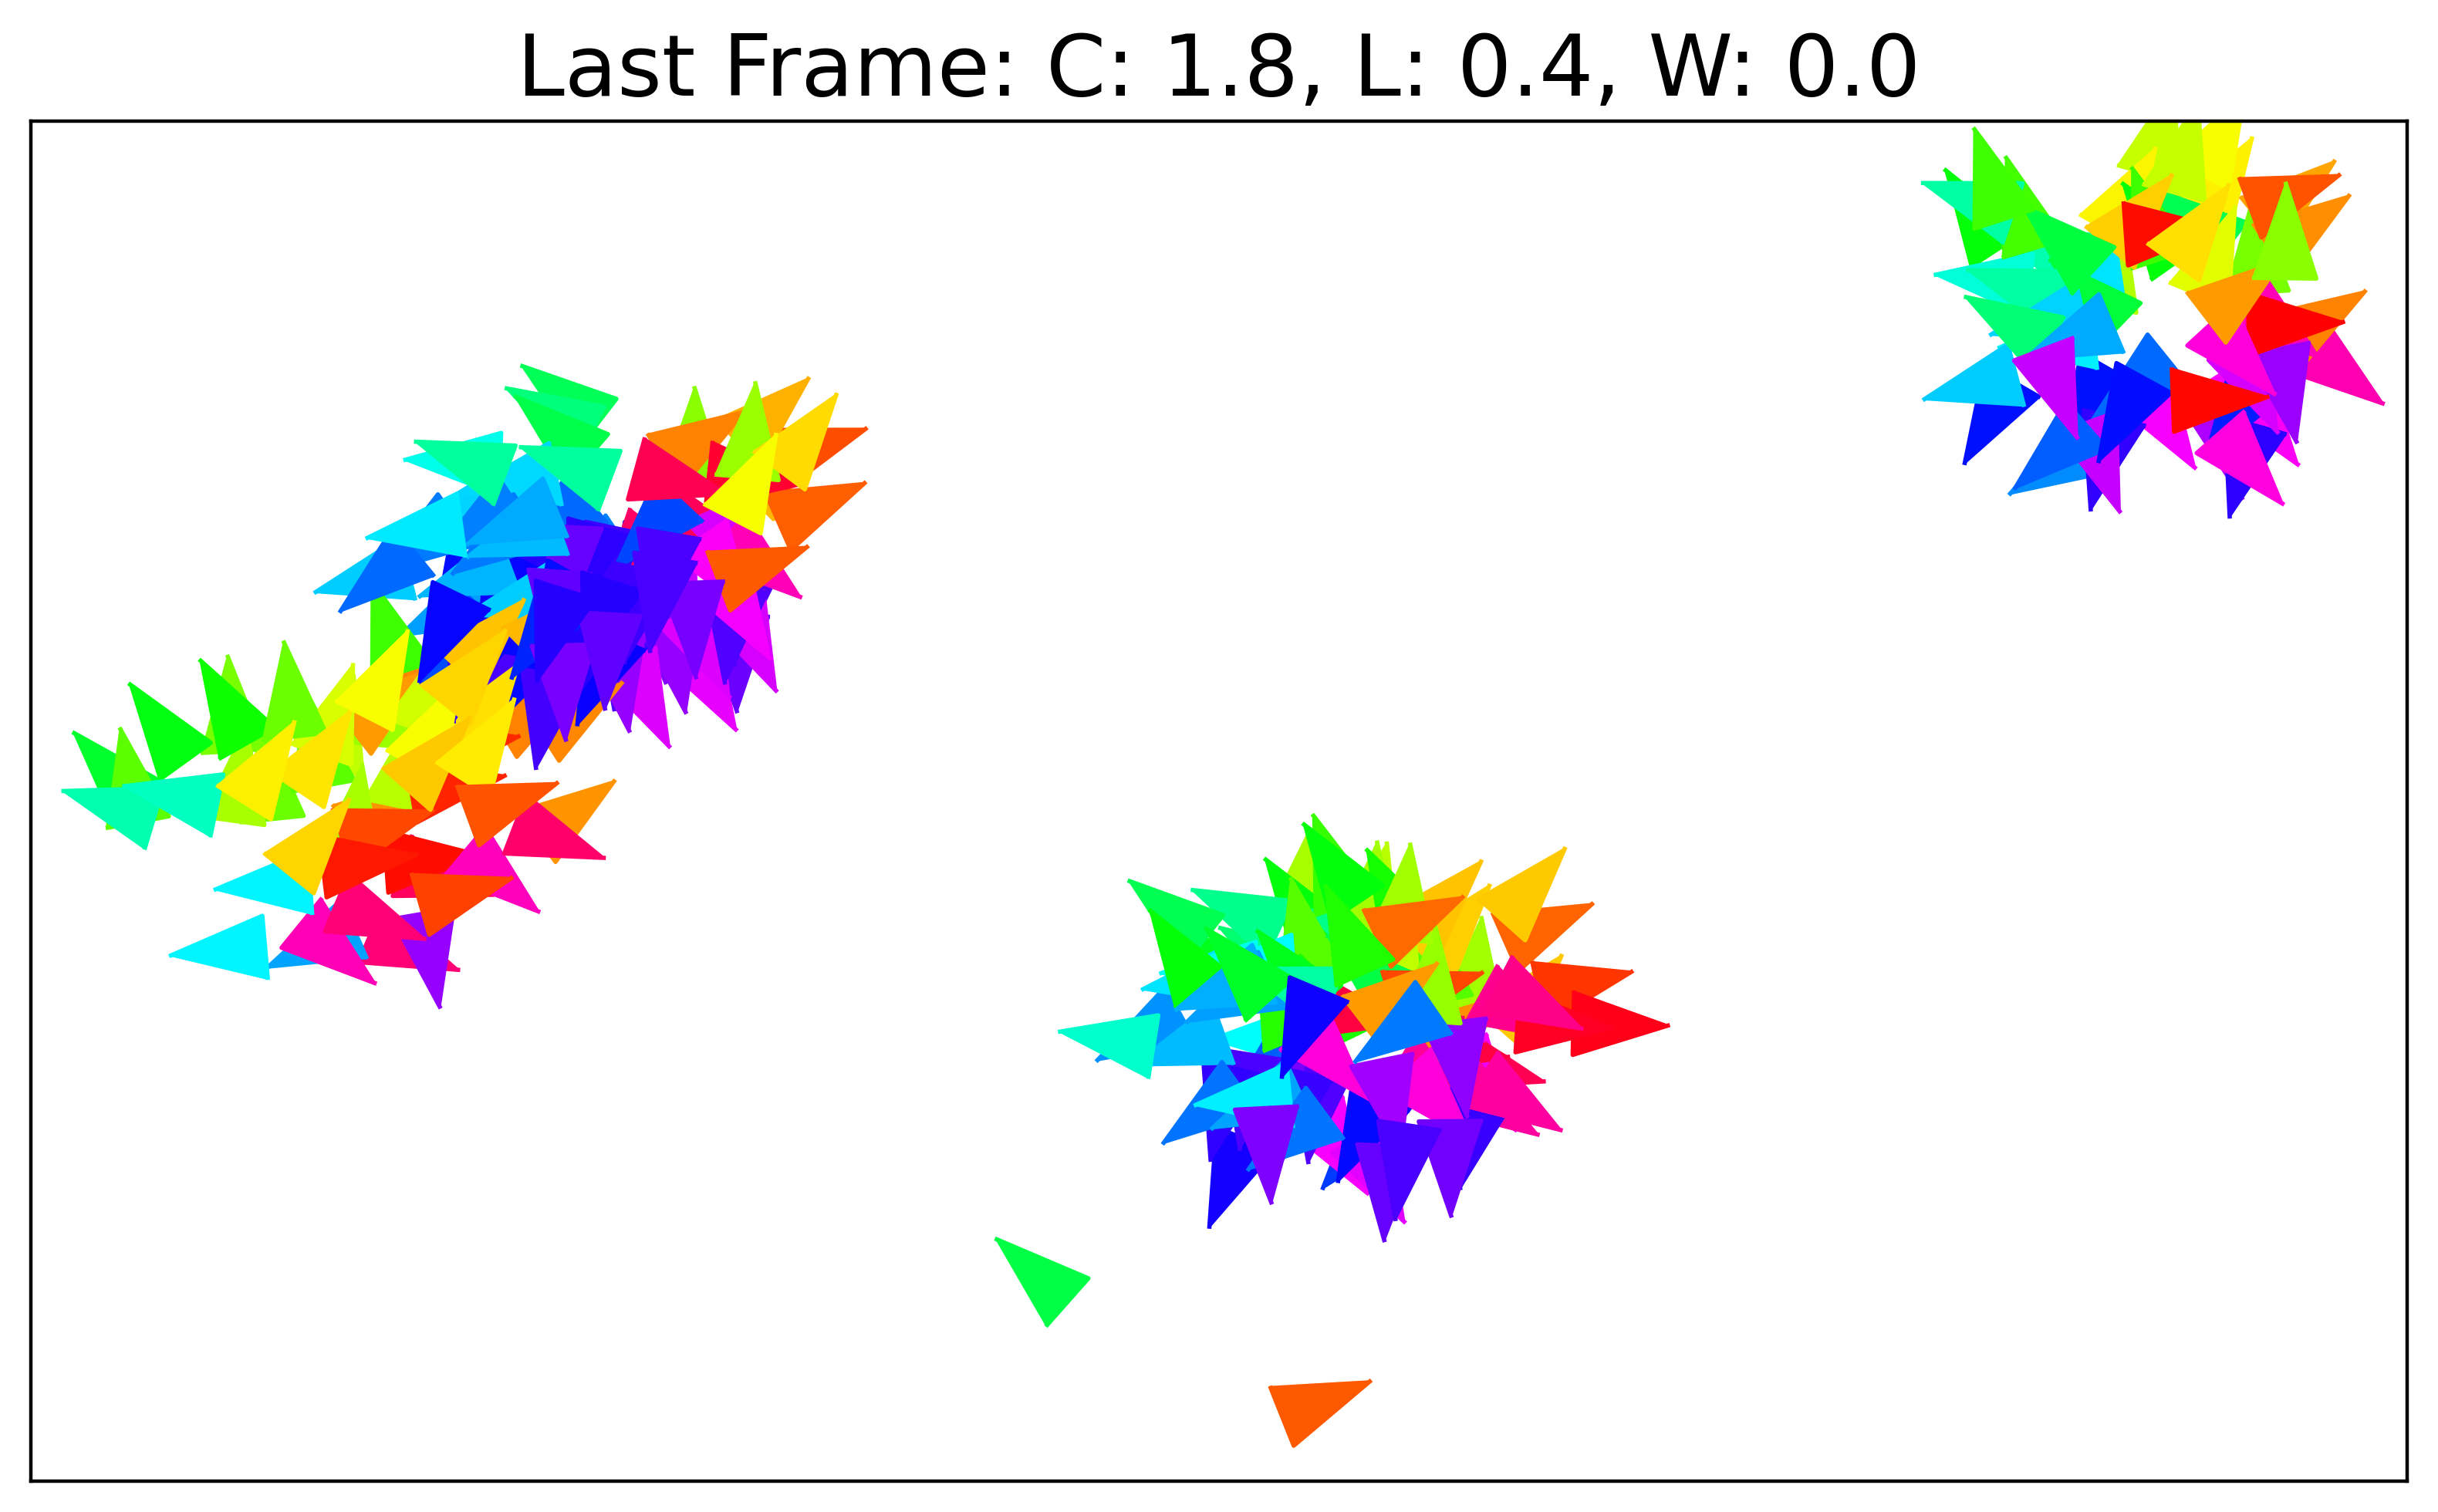

In [24]:
#VANILLA CROCKER
#Which DataFrame columns to use as dimensions
track_len=10

#List of frame values to use, must be aligned for direct comparison
FRAME_LIST = range(20,120,1) #starts at 10 because of angle computation
#compute the data for the crocker plot
frame_idx=100

Cs = np.linspace(0.1,3.0,30)
Ls = np.linspace(0.1,3.0,30)
Ws = np.linspace(0.0,0.1,11)


for Widx, CL_tup in align_last_frame.items():
    print(Widx)
    for CL_idx, CL_pair in enumerate(CL_tup):
        Cidx, Lidx = CL_pair
        # Get true data frame:
        true_PATH = './Simulated_Grid/ODE_Align/Cidx_'+str(Cidx).zfill(2)+'_Lidx_'+str(Lidx).zfill(2)+'_Widx_'+str(Widx).zfill(2)+'/run_1/df.pkl'
        true_df = pd.read_pickle(true_PATH)
    
        new_data = compute_angle_df(true_df,FRAME_LIST,track_len)
        # print('new data size: ' + str(new_data.shape))

        fig=plt.figure(figsize=(8,5),dpi=400)
        ax = fig.add_subplot(111)
        x = new_data[new_data['frame']==frame_idx].x.values 
        y = new_data[new_data['frame']==frame_idx].y.values
        deg_xy = new_data[new_data['frame']==frame_idx].angle.values
        for idx,val in enumerate(x):
            marker, scale = gen_arrow_head_marker(deg_xy[idx])
            markersize=50
            sc=ax.scatter(x[idx],y[idx],c=deg_xy[idx],vmin=0,vmax=360,cmap='hsv',marker=marker, s=(markersize*scale)**2)

        ax.tick_params(left = False, right = False, labelleft = False,
                    labelbottom = False, bottom = False)
        
        # label = ['A', 'B', 'C', 'D', 'E']
        # ax.set_title(f'Last Frame : {label[CL_idx]}.{Widx}', fontsize=20)
        
        # label = letter_dict[Widx][CL_idx]
        # ax.set_title(f'Last Frame : {label}.{Widx}', fontsize=20)

        Cval = Cs[Cidx]
        Lval = Ls[Lidx]
        Wval = Ws[Widx]

        ax.set_title('Last Frame: C: '+ str(Cval) + ', L: ' + str(Lval) + ', W: ' + str(Wval), fontsize=20)
        plt.tight_layout()
        # 
        folder_path = 'Last_Frames'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path, exist_ok=True)
            
        file_name = '/Cidx_'+str(Cidx).zfill(2)+'_Lidx_'+str(Lidx).zfill(2)+'_Widx_'+str(Widx).zfill(2)+'_LastFrame.pdf'
        plt.savefig(folder_path + file_name, bbox_inches='tight')
        
        print(f'Saved & Completed WCL: {Widx}_{Cidx}_{Lidx}')

#     # Get ABC results:
#     ABC_path = './Simulated_Grid/ODE/Cidx_'+str(Cidx).zfill(2)+'_Lidx_'+str(Lidx).zfill(2)+'/run_1/ABC_pars_weighted/df_ABC.pkl'
#     ABC_df = pd.read_pickle(ABC_path)
    
#     new_data = compute_angle_df(ABC_df,FRAME_LIST,track_len)

#     fig=plt.figure(figsize=(10,8),dpi=400)
#     ax = fig.add_subplot(111)
#     x = new_data[new_data['frame']==frame_idx].x.values 
#     y = new_data[new_data['frame']==frame_idx].y.values
#     deg_xy = new_data[new_data['frame']==frame_idx].angle.values
#     for idx,val in enumerate(x):
#         marker, scale = gen_arrow_head_marker(deg_xy[idx])
#         markersize=50
#         sc=ax.scatter(x[idx],y[idx],c=deg_xy[idx],vmin=0,vmax=360,cmap='hsv',marker=marker, s=(markersize*scale)**2)
# #     cbar = plt.colorbar(sc)
# #     for t in cbar.ax.get_yticklabels():
# #         t.set_fontsize(20)
#     # ax.set_xlim([-1.05,1.05])
#     # ax.set_ylim([-1.05,1.05])
# #     ax.tick_params(axis='x', labelsize=20)
# #     ax.tick_params(axis='y', labelsize=20)
# #     ax.set_axis_off()
#     ax.tick_params(left = False, right = False, labelleft = False,
#                    labelbottom = False, bottom = False)
#     plt.tight_layout()
#     plt.savefig('./Simulated_Grid/ODE/Cidx_'+str(Cidx).zfill(2)+'_Lidx_'+str(Lidx).zfill(2)+'/run_1/ABC_pars_weighted/ABC_last_frame_'+'Cidx_'+str(Cidx).zfill(2)+'_Lidx_'+str(Lidx).zfill(2)+'.pdf',bbox_inches='tight')

In [28]:
new_data

,x,y,angle,mag,frame
0,18.876444,13.805491,284.178557,2.512459,20
1,13.886687,17.492393,26.213021,2.238469,20
2,18.388284,7.356459,238.315246,2.556732,20
3,10.568993,11.818778,10.536038,1.767346,20
4,26.091727,17.501074,288.508971,2.645678,20
...,...,...,...,...,...
29995,8.423988,11.443951,289.397650,0.970402,119
29996,14.466418,7.089900,204.252648,0.521256,119
29997,9.058905,10.813084,286.245573,1.286349,119
29998,8.713325,12.617168,24.343327,1.475683,119
